# Churn Analytics
## Time to Churn

Customer churn analytics is used to predict the point in time when a customer will no longer be considered an 'active' customer. A customer may churn by:
- withdrawing from service or 
- choosing to not renew their subscription. 

For most businesses retaining existing customers is equally important as acquiring new ones. It is crucial to not only predict which customers are likely to churn, but also which customers are likely to stay active. Some businesses have a loyal customer population who will not leave until many years down the road, so in the short-term they would always be active. 

This scenario can be modeled as a cure rate survival (crs) analysis problem with the following characteristics:
 - <b>Event of interest</b>: Customer no longer using our services
 - <b>Time-to-event</b>: The time difference between the acquisition of a new customer and their leaving
 - <b>Cured population</b>: Loyal customers who never leave the service
 
 

In [36]:
import warnings
warnings.filterwarnings('ignore')

## Imports 

In [37]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from apd_crs.survival_analysis import SurvivalAnalysis
from apd_crs.datasets import load_telco
from sklearn.model_selection import train_test_split

## The Churn Dataset

We investigate on a Telco dataset from Kaggle. More information about the features in the data can be obtained from: https://www.kaggle.com/blastchar/telco-customer-churn

In [38]:
# loading the data
dataset = load_telco()  
data, labels, times = dataset.data, dataset.target, dataset.target_times


In [39]:
# We can access the dataset information with these keys

dataset.keys()

dict_keys(['data', 'target', 'target_times', 'feature_names', 'target_name', 'target_time'])

In [40]:
# View the head of the data

dataset['data'].head()

,customerID,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,Female,0,Yes,No,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,Male,0,No,No,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50
2,3668-QPYBK,Male,0,No,No,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,Male,0,No,No,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,Female,0,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65


## Using the SurvivalAnalysis Class
The apd_crs module expects censored data to be marked using _censor_label_ and cured data to be marked using _cure_label_. These can be obtained with the get_censor_label and get_cure_label methods as follows

In [41]:
# Instantiate the SurvivalAnalysis class and get labels
model = SurvivalAnalysis()
non_cure_label = model.get_non_cure_label()
censor_label = model.get_censor_label()

The load_telco() method returns a dataset where the labels have been suitably preprocessed already. However, make sure to suitably convert the labels when applying SurvivalAnalysis on your datasets!

In [42]:
# In telco dataset, label of 2 implies censored, and 1 implies non_cured
labels = labels.replace({2: censor_label, 1: non_cure_label})

## Data Preprocessing
We drop rows with missing values and the column customerID as it has no useful information for our model

In [43]:
missing_idx = data.isna().any(axis=1)
data = data[~missing_idx]
labels = labels[~missing_idx]
times = times[~missing_idx]
data.drop(columns="customerID", inplace=True)  # Drop uninformative column

## One-hot encoding

Our data includes columns such as "SeniorCitizen" which could take the value "yes" to denote whether the customer is a senior citizen, or "no" to denote that the customer is not a senior citizen. We obviously need to convert categorical values into numerical values before we can use them for our model. This is achieved through one-hot encoding. 

In [44]:
categorical_columns = ["gender", "Partner", "Dependents", "PhoneService", "MultipleLines",
                       "InternetService", "OnlineSecurity", "OnlineBackup", "DeviceProtection", 
                       "TechSupport", "StreamingTV", "StreamingMovies", "Contract", "PaperlessBilling", "PaymentMethod"]

encoded_data = pd.get_dummies(data, columns=categorical_columns, prefix=categorical_columns)

## Train test split

We split the data into training and test sets. The model is fit on training data and evaluated on test data

In [45]:
# Test train split: To evaluate test performance we split the data into training and testing data;
# test_size is percentage going to test data
test_size = 0.33
(training_data, test_data, training_labels, 
 test_labels, training_times, test_times) = train_test_split(encoded_data, labels, times, test_size=test_size)


## Scaling
To ensure that a certain feature does not dominate other features due to its numerical range, we scale all features so they lie within the same range

In [46]:
# Scale covariates: 
scaler = StandardScaler()
scaled_training_data = scaler.fit_transform(training_data)
# Scale times:
scaled_training_times = training_times/training_times.max()

## Using the SurvivalAnalysis Class: Model Fitting

In [47]:
# surv_reg_term controls regularization for the fitting of lifetime parameters
# is_scar=True means we use the selected completely at random assumption to estimate cure probability

model.survival_fit(scaled_training_data, training_labels, scaled_training_times, surv_reg_term=1., is_scar=True)


Before evaluating results, make sure to apply the same scaling that was applied to training data

In [48]:
scaled_test_data = scaler.transform(test_data)
scaled_test_times = test_times/training_times.max()

## Evaluating Model Performance

### Danger 
The Danger associated with an individual is a measure of the individual's risk of facing the event. It can take on any real number.

The higher the Danger, the higher the risk associated with an individual. E.g. an individual with Danger -1.2 is less at risk than one with Danger 1.0.

The danger can be calculated using the predict_danger method,





### Concordance Index (C-Index)

Two individuals are comparable if one experiences the event before the other. A pair of individuals is concordant if the one which "died" first has a higher danger. If our model is fit well, an individual for which we predict a higher danger is more likely to face the event of interest before another individual for which we predict a lower danger. This idea if formalized with the notion of c-index.

C-Index = ratio of concordant pairs to comparable pairs. 

Clearly C-index is in $[0,1]$ and the higher the better. 

Random guessing $\Rightarrow$ C-index = 0.5

### Danger Calculation

In [49]:
train_danger = model.predict_danger(scaled_training_data, training_labels)
test_danger = model.predict_danger(scaled_test_data, test_labels)


### C-Index Calculation

In [50]:
train_score = model.cindex(scaled_training_times, training_labels, train_danger)
test_score = model.cindex(scaled_test_times, test_labels, test_danger)
print(f"c-index score on train set is {train_score}")
print(f"c-index score on test set is {test_score}")

c-index score on train set is 0.8593593919327659
c-index score on test set is 0.8498074327523536


## Overall Risk Factors
The relative risk factors associated with every covariate in the dataset can be obtained using the get_risk_factors methood. Let us retrieve the top 10 factors in absolute value to get an idea of what they are

<AxesSubplot:>

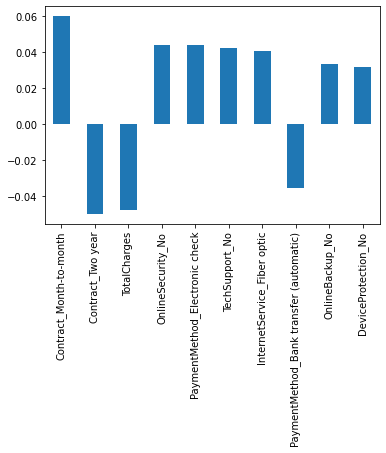

In [51]:
factors = model.get_risk_factors()
n_factors = len(factors)
risk_factors = pd.Series({encoded_data.columns[i]: factors[i] for i in range(n_factors)})
top_ten_factors_in_absvalue = risk_factors.abs().sort_values(ascending=False)[0:10]
risk_factors.filter(top_ten_factors_in_absvalue.index).plot.bar()

## Individual Predictions
The probability of survival of any individual decreases with time. Let us plot the overall survival function for the first five individuals in the test set. Note that the times have been normalized to lie between 0 and 1. 

In [52]:
# We choose this particular set of times so we can clearly see the decrease of the survival functions in this example
times = np.arange(0, 0.003, 0.00005)
repeats_array = np.tile(times, (len(test_data), 1))
ovpr = model.predict_overall_survival(scaled_test_data, repeats_array, test_labels)
# We can include the corresponding probabilities of cure in a legend
cure_probs = [np.around((model.predict_cure_proba(scaled_test_data, test_labels)[0:5, 0])[i], decimals=2)
              for i in range(5)]



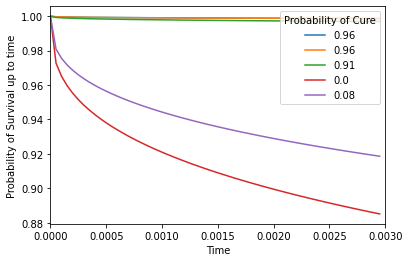

In [53]:
y = ovpr[0:5, :]
x = times
plt.plot(x, y.T)
plt.xlim([0, 0.003])
plt.xlabel("Time")
plt.ylabel("Probability of Survival up to time")
plt.legend(labels=cure_probs, loc="upper right", title="Probability of Cure")
plt.show()